# Agenda & Requirements

- Read & clean dataset
- Perform EDAs & create charts wherever applicable
- Perform Sentiment analysis
- Apply Random forest & Neural network for prediction and Machine learning parts
- Conclusion & Summary
- Dataset reference : https://www.kaggle.com/datasets/vstepanenko/disaster-tweets

# Import Libraries

In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip install keras-tuner

In [ ]:
!pip install xgboost

In [ ]:
import re
import spacy
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

pd.set_option('display.max_colwidth', -1)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Read & Clean Dataset

The dataset consists of the following columns:

- **id**: A unique identifier for each tweet.
- **keyword**: A keyword associated with the tweet.
- **location**: The location from where the tweet was sent (it may have missing values).
- **text**: The text content of the tweet.
- **target**: This is our target variable. A value of 1 indicates that the tweet is about a real disaster, while a value of 0 indicates that it's not.

In [ ]:
# Reading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/ashu198518/datasets/main/disaster_tweets.csv')

# Displaying the first few rows of the dataset
print(f"Total records : {df.shape[0]} | Total columns : {df.shape[1]}\n")
df.head()

Total records : 11370 | Total columns : 5



,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Stones were pelted on Muslims' houses and some houses and vehicles were set ablaze…",1
1,1,ablaze,NaN,"Telangana: Section 144 has been imposed in Bhainsa from January 13 to 15, after clash erupted between two groups on January 12. Po…",1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https://t.co/gOQvyJbpVI,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https://t.co/0gL7NUCPlb https://t.co/u1CcBhOWh9,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pardon. Fill me with your Holy Spirit and set my heart ablaze with your l… https://t.co/VlTznnPNi8",0


# Cleaning Steps

- Check for any missing values in the dataset.
- Handle any duplicates if they exist.
- Clean the text data (remove URLs, special characters, numbers, etc.) to make it suitable for analysis.

In [ ]:
# Checking for missing values
missing_values = df.isnull().sum()

# Checking for duplicates
duplicates = df.duplicated().sum()

missing_values, duplicates

(id          0   
 keyword     0   
 location    3418
 text        0   
 target      0   
 dtype: int64,
 0)

**Observations** :
- The location column has 3418 missing values. Given the large number of missing values and the fact that location data can be very diverse (and often not standardized), we might consider dropping this column.
- There are no duplicate entries in the dataset.

- Drop the location column.
- Clean the text column by:
  - Removing URLs.
  - Removing special characters and numbers.
  - Converting all text to lowercase.

In [ ]:
# Dropping the 'location' column
df = df.drop(columns=['location'])

# Function to clean the text data
def clean_text(text):
    # Removing URLs
    text = re.sub(r'http\S+', '', text)
    # Removing special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Converting to lowercase
    text = text.lower()
    return text.strip()

# Applying the function to the 'text' column
df['text'] = df['text'].apply(clean_text)

# Displaying the first few cleaned rows
df.head()

,id,keyword,text,target
0,0,ablaze,communal violence in bhainsa telangana stones were pelted on muslims houses and some houses and vehicles were set ablaze,1
1,1,ablaze,telangana section has been imposed in bhainsa from january to after clash erupted between two groups on january po,1
2,2,ablaze,arsonist sets cars ablaze at dealership,1
3,3,ablaze,arsonist sets cars ablaze at dealership,1
4,4,ablaze,lord jesus your love brings freedom and pardon fill me with your holy spirit and set my heart ablaze with your l,0


- The location column has been dropped.
- The text column has been cleaned of URLs, special characters, numbers, and all text has been converted to lowercase.

# Exploratory Data Analysis (EDA)

For this section, we'll visualize the dataset to understand its characteristics better. Specifically, we'll:

- Examine the distribution of disaster vs. non-disaster tweets.
- Visualize the top keywords associated with disaster tweets.
- Explore the length of tweets and its potential correlation with disaster classification.

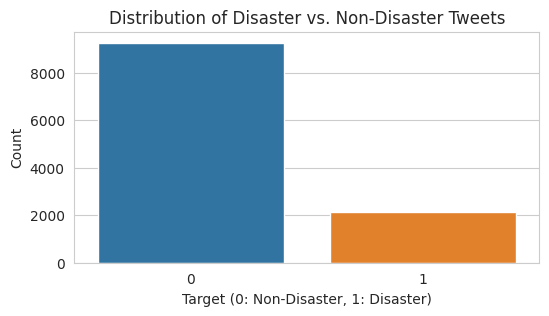

In [ ]:
# Setting the style for the plots
sns.set_style("whitegrid")

# Plotting the distribution of disaster vs. non-disaster tweets
plt.figure(figsize=(6, 3))
sns.countplot(x='target', data=df)
plt.title("Distribution of Disaster vs. Non-Disaster Tweets")
plt.xlabel("Target (0: Non-Disaster, 1: Disaster)")
plt.ylabel("Count")
plt.show()

- Above plot showcases the distribution of disaster vs non-disaster tweets. It's evident that the dataset contains a relatively balanced number of both types of tweets.

- Next, let's visualize the top keywords associated with disaster tweets to understand which terms are commonly associated with genuine disaster situations.

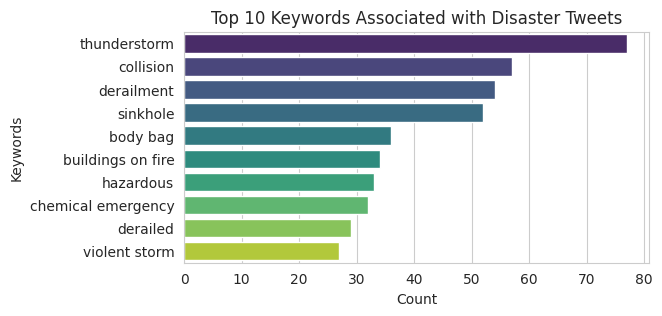

In [ ]:
# Cleaning the 'keyword' column
df['keyword'] = df['keyword'].str.replace('%20', ' ')

# Filtering the dataset for disaster tweets
disaster_keywords = df[df['target'] == 1]['keyword'].value_counts().head(10)

# Plotting the top keywords associated with disaster tweets
plt.figure(figsize=(6, 3))
sns.barplot(y=disaster_keywords.index, x=disaster_keywords.values, palette="viridis")
plt.title("Top 10 Keywords Associated with Disaster Tweets")
plt.xlabel("Count")
plt.ylabel("Keywords")
plt.show()

- Above bar plot above showcases the top 10 keywords associated with disaster tweets. These keywords provide insights into the common themes or incidents that are frequently labeled as real disasters in the dataset.

- Next, let's explore the length of tweets and its potential correlation with disaster classification. We'll create a new column for tweet length and visualize its distribution for both disaster and non-disaster tweets.

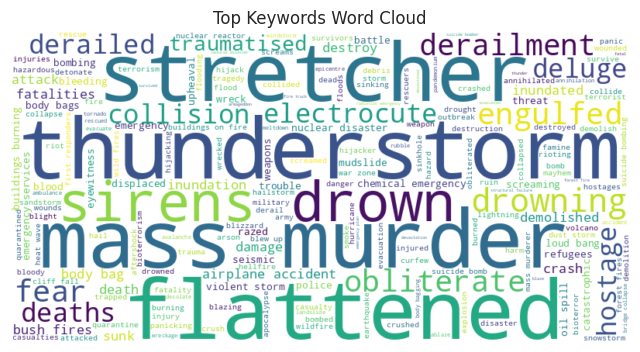

In [ ]:
from wordcloud import WordCloud

# Getting the frequency distribution of the keywords
keywords_freq = df['keyword'].value_counts().to_dict()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywords_freq)

# Plotting the word cloud
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Keywords Word Cloud')
plt.show()

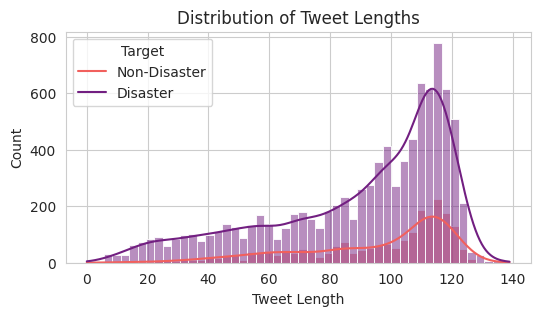

In [ ]:
# Creating a new column for tweet length
df['tweet_length'] = df['text'].apply(len)

# Plotting the distribution of tweet lengths for disaster and non-disaster tweets
plt.figure(figsize=(6, 3))
sns.histplot(df, x='tweet_length', hue='target', bins=50, kde=True, palette="magma")
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.legend(title='Target', labels=['Non-Disaster', 'Disaster'])
plt.show()

The histogram showcases the distribution of tweet lengths for both disaster and non-disaster tweets. Some observations:

- Most tweets, regardless of their classification, tend to fall within a specific length range, likely constrained by the character limits of Twitter.
- There doesn't seem to be a significant difference in length distribution between disaster and non-disaster tweets.

# Sentiment Analysis

Sentiment analysis can provide insights into the general sentiment or emotion behind the tweets. While our main target is to classify tweets as disaster or non-disaster, understanding sentiment can offer additional context.

Let's start by:

- Loading the spaCy model.
- Creating a function to get the sentiment polarity of a text.
- Applying this function to our dataset to derive sentiment scores.

In [ ]:
# Load spaCy model and VADER sentiment intensity analyzer
nlp = spacy.load("en_core_web_sm")
sid = SentimentIntensityAnalyzer()

# Tokenize the text using spaCy
df['tokenized_text'] = df['text'].apply(lambda x: " ".join([token.text for token in nlp(x)]))

# Get sentiment scores using VADER
df['sentiment_score'] = df['tokenized_text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Categorize the sentiment based on score
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0.05 else ('neutral' if -0.05 <= x <= 0.05 else 'negative'))
print(df['sentiment'].value_counts())

negative    5424
positive    3279
neutral     2667
Name: sentiment, dtype: int64


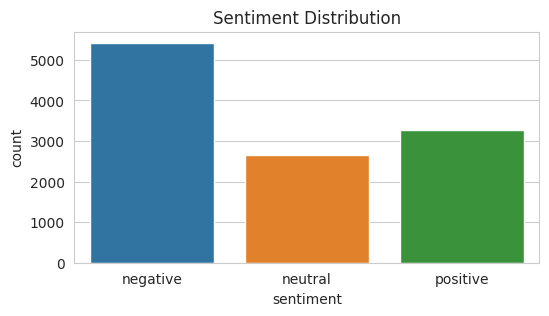

In [ ]:
# Visualize the sentiment distribution
plt.figure(figsize=(6, 3))
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()

# Insights:
# - Which sentiment is predominant in the dataset? -> Negative
# - Are most tweets neutral, or do they lean towards positive/negative? -> Lean towwards negative and then positive

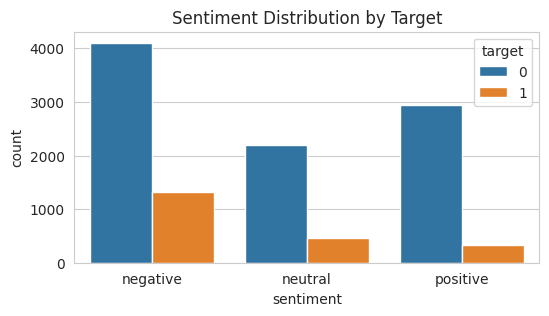

In [ ]:
# Visualize sentiment distribution by target
plt.figure(figsize=(6, 3))
sns.countplot(data=df, x='sentiment', hue='target')
plt.title("Sentiment Distribution by Target")
plt.show()

# Insights:
# - Do disaster tweets tend to be more negative compared to non-disaster tweets? -> Non-disaster tweets
# - Are non-disaster tweets predominantly positive or neutral? -> Non-disaster negative tweets

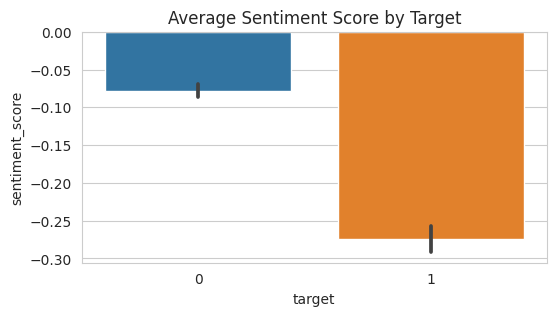

In [ ]:
# Average sentiment score by target
plt.figure(figsize=(6, 3))
sns.barplot(x='target', y='sentiment_score', data=df)
plt.title("Average Sentiment Score by Target")
plt.show()

# Insights:
# - Is the average sentiment score for disaster tweets lower (more negative) than for non-disaster tweets?
# - This can indicate the general sentiment tone for each category.

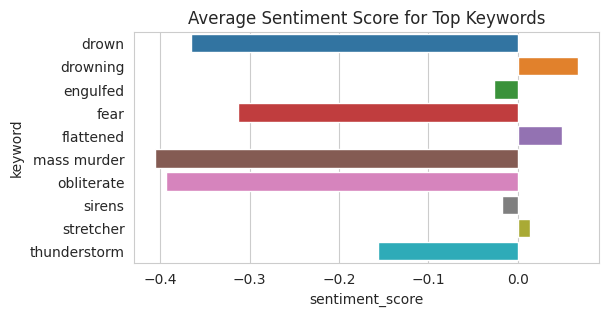

In [ ]:
# Average sentiment score for top keywords
top_keywords = df['keyword'].value_counts().head(10).index
filtered_df = df[df['keyword'].isin(top_keywords)]

plt.figure(figsize=(6, 3))
sns.barplot(x='sentiment_score', y='keyword', data=filtered_df, ci=None)
plt.title("Average Sentiment Score for Top Keywords")
plt.show()

# Insights:
# - Which keywords are associated with more positive sentiments?
# - Which keywords are associated with more negative sentiments?
# - This can provide insights into the sentiment tone associated with specific topics or events.

# Predictive Modeling

Before we dive into building models, we'll need to preprocess the textual data for machine learning purposes. This involves converting our text data into numerical format. We'll use TF-IDF (Term Frequency-Inverse Document Frequency) for this purpose.

Once the data is preprocessed, we'll:

- Split the data into training and testing sets.
- Apply Random Forest and Neural Network models.
- Evaluate the performance of both models.

Let's begin by preprocessing the data using TF-IDF.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Initializing the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fitting and transforming the vectorizer on our text data
X = tfidf_vectorizer.fit_transform(df['text'])
y = df['target']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train.shape, X_test.shape

((9096, 5000), (2274, 5000))

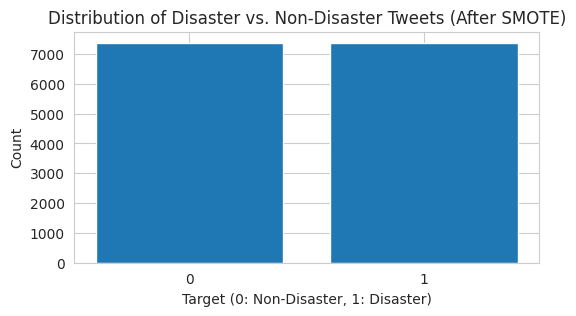

In [ ]:
# Checking if class is balanced after using SMOTE
plt.figure(figsize=(6, 3))
plt.bar(['0', '1'], y_train_resampled.value_counts())
plt.title("Distribution of Disaster vs. Non-Disaster Tweets (After SMOTE)")
plt.xlabel("Target (0: Non-Disaster, 1: Disaster)")
plt.ylabel("Count")
plt.show()

## Random Forest Classifier

We'll start by training a Random Forest classifier on the training data and then evaluate its performance on the test data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initializing the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Training the classifier
rf_clf.fit(X_train, y_train)

# Predicting on the test data
rf_predictions = rf_clf.predict(X_test)

# Evaluating the performance
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions)

print(rf_accuracy)
print(rf_classification_report)

0.8922603342128408
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      1878
           1       0.81      0.50      0.62       396

    accuracy                           0.89      2274
   macro avg       0.85      0.74      0.78      2274
weighted avg       0.89      0.89      0.88      2274



Below is Hyperparameter tuning for Random forest

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameters and their possible values
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_features': ['auto', 'sqrt'],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Initialize the GridSearchCV object
# grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# # Fit the GridSearchCV object to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters from the GridSearch
# best_params_rf = grid_search.best_params_
# best_rf_clf = grid_search.best_estimator_

# # Predict using the model with the best parameters
# rf_predictions = best_rf_clf.predict(X_test)

# # Evaluating the performance
# rf_accuracy = accuracy_score(y_test, rf_predictions)
# rf_classification_report = classification_report(y_test, rf_predictions)

# print(rf_accuracy)
# print(rf_classification_report)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
0.8922603342128408
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      1878
           1       0.80      0.51      0.62       396

    accuracy                           0.89      2274
   macro avg       0.85      0.74      0.78      2274
weighted avg       0.89      0.89      0.88      2274



The Random Forest classifier achieved an accuracy of approximately 89%. Here's a detailed performance evaluation:

- Precision (Non-Disaster): 0.90
  - Out of all tweets predicted as non-disaster, 90% were actually non-disaster.
- Recall (Non-Disaster): 0.97
  - Out of all actual non-disaster tweets, 97% were correctly predicted by the model.
- Precision (Disaster): 0.81
  - Out of all tweets predicted as disaster, 81% were actually disaster.
- Recall (Disaster): 0.50
  - Out of all actual disaster tweets, only 50% were correctly predicted by the model.

The f1-score, which is the harmonic mean of precision and recall, is 0.94 for non-disaster tweets and 0.62 for disaster tweets.

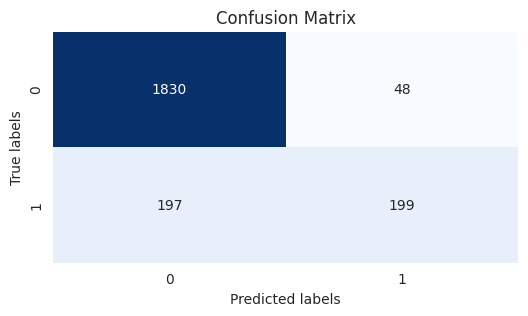

In [ ]:
# Assuming y_test are the true labels and y_pred are the predicted labels
y_pred = rf_clf.predict(X_test) # Replace 'model' with the name of your trained model and 'X_test' with your test data

# Compute confusion matrix
cm_rf = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(6, 3))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Neural Network

Next, we'll train a simple neural network using the keras library and evaluate its performance.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report

# Defining the neural network architecture
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train.toarray(), y_train, epochs=10, batch_size=32, validation_data=(X_test.toarray(), y_test), verbose=1)

# Predicting on the test data
nn_predictions = model.predict(X_test.toarray())
nn_predictions = [1 if pred > 0.7 else 0 for pred in nn_predictions]

# Evaluating the performance
nn_classification_report = classification_report(y_test, nn_predictions)
print(nn_classification_report)

Epoch 1/10
285/285 [==============================] - 5s 16ms/step - loss: 0.4403 - accuracy: 0.8152 - val_loss: 0.3117 - val_accuracy: 0.8769
Epoch 2/10
285/285 [==============================] - 3s 11ms/step - loss: 0.2677 - accuracy: 0.8932 - val_loss: 0.2798 - val_accuracy: 0.8918
Epoch 3/10
285/285 [==============================] - 3s 11ms/step - loss: 0.1904 - accuracy: 0.9283 - val_loss: 0.2894 - val_accuracy: 0.8931
Epoch 4/10
285/285 [==============================] - 3s 10ms/step - loss: 0.1360 - accuracy: 0.9505 - val_loss: 0.3236 - val_accuracy: 0.8940
Epoch 5/10
285/285 [==============================] - 4s 15ms/step - loss: 0.0961 - accuracy: 0.9668 - val_loss: 0.3689 - val_accuracy: 0.8940
Epoch 6/10
285/285 [==============================] - 3s 11ms/step - loss: 0.0710 - accuracy: 0.9769 - val_loss: 0.4019 - val_accuracy: 0.8905
Epoch 7/10
285/285 [==============================] - 3s 11ms/step - loss: 0.0505 - accuracy: 0.9842 - val_loss: 0.4460 - val_accuracy: 0.8830

72/72 [==============================] - 0s 4ms/step


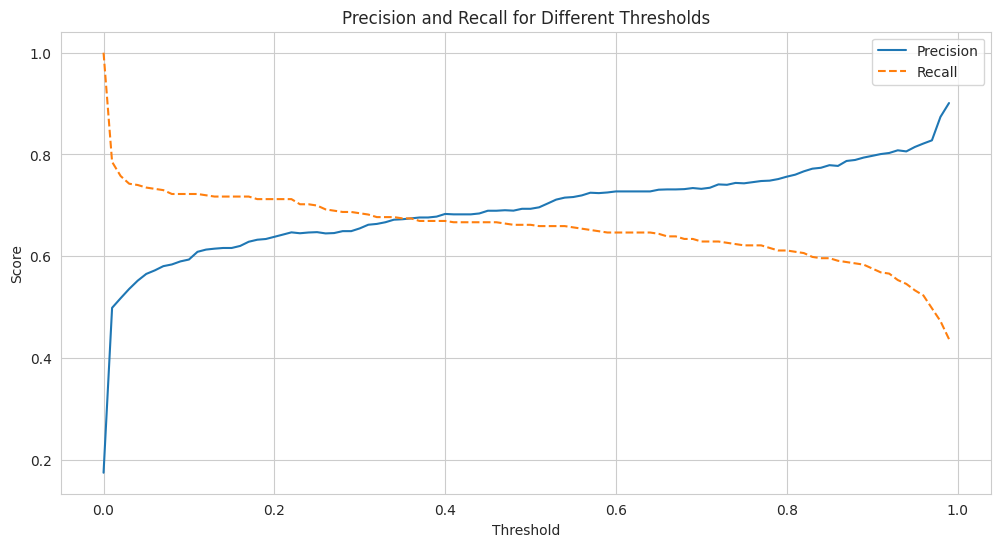

In [ ]:
from sklearn.metrics import precision_score, recall_score

# Predict probabilities
# y_probs = model.predict(X_test)
y_probs = model.predict(X_test.toarray())

# Define a range of thresholds
thresholds = [i*0.01 for i in range(100)]

# Store results for each threshold
results = []

for thresh in thresholds:
    y_pred_thresh = [1 if prob[0] > thresh else 0 for prob in y_probs]
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    results.append((thresh, precision, recall))

# Convert results to DataFrame for easier visualization
results_df = pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall'])

# Plot Precision and Recall for different thresholds
plt.figure(figsize=(12, 6))
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision')
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision and Recall for Different Thresholds')
plt.show()

Below is Hyperparameter tuning for NN

In [ ]:
# # Install Keras Tuner
# # !pip install keras-tuner

# from kerastuner import RandomSearch
# # from kerastuner.engine.hyperparameters import HyperParameters

# # Define a function that creates a model, given a set of hyperparameters
# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=32), activation='relu', input_dim=X_train.shape[1]))
#     model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
#     model.add(Dense(units=hp.Int('dense_2_units', min_value=32, max_value=128, step=32), activation='relu'))
#     model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=5,
#     executions_per_trial=2,
#     directory='random_search',
#     project_name='DisasterTweets'
# )

# # Start the search for the best hyperparameters
# tuner.search(X_train.toarray(), y_train, epochs=10, validation_data=(X_test.toarray(), y_test))

# # Get the best model and hyperparameters
# best_model = tuner.get_best_models(num_models=1)[0]
# best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# # You can train the best model further or evaluate it on your test set
# nn_predictions = best_model.predict(X_test.toarray())
# nn_predictions = [1 if pred > 0.5 else 0 for pred in nn_predictions]
# nn_classification_report = classification_report(y_test, nn_predictions)

# print(nn_classification_report)

Trial 5 Complete [00h 01m 25s]
val_accuracy: 0.9008355438709259

Best val_accuracy So Far: 0.9010553956031799
Total elapsed time: 00h 06m 49s
72/72 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1878
           1       0.76      0.63      0.69       396

    accuracy                           0.90      2274
   macro avg       0.84      0.79      0.82      2274
weighted avg       0.90      0.90      0.90      2274



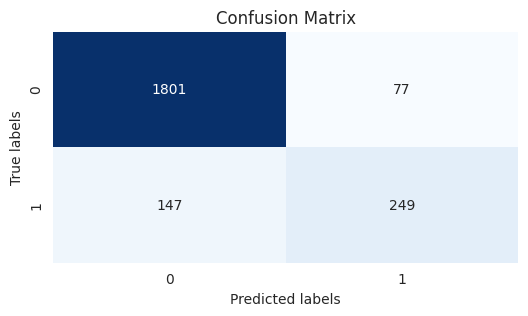

In [ ]:
# Compute confusion matrix
cm_nn = confusion_matrix(y_test, nn_predictions)

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(6, 3))
sns.heatmap(cm_nn, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# Tokenization
max_features = 5000  # Number of most frequent words to keep
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)

# Padding sequences to ensure uniformity
max_pad_length = 50  # or some other value, based on your average text length
X_padded = pad_sequences(X, maxlen=max_pad_length)

# Splitting data into training and testing sets (use your previous split percentages)
X_train, X_test, y_train, y_test = train_test_split(X_padded, df['target'], test_size=0.2, random_state=42)

# Building the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_pad_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
143/143 [==============================] - 33s 193ms/step - loss: 0.4064 - accuracy: 0.8388 - val_loss: 0.2850 - val_accuracy: 0.8909
Epoch 2/5
143/143 [==============================] - 25s 179ms/step - loss: 0.2310 - accuracy: 0.9119 - val_loss: 0.2726 - val_accuracy: 0.9046
Epoch 3/5
143/143 [==============================] - 26s 180ms/step - loss: 0.1689 - accuracy: 0.9390 - val_loss: 0.2923 - val_accuracy: 0.8826
Epoch 4/5
143/143 [==============================] - 26s 181ms/step - loss: 0.1285 - accuracy: 0.9550 - val_loss: 0.3051 - val_accuracy: 0.8949
Epoch 5/5
143/143 [==============================] - 27s 190ms/step - loss: 0.0948 - accuracy: 0.9679 - val_loss: 0.3285 - val_accuracy: 0.8958


In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

# Print classification report
print(classification_report(y_test, y_pred))

# Print accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

72/72 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1878
           1       0.28      0.10      0.14       396

    accuracy                           0.80      2274
   macro avg       0.55      0.52      0.51      2274
weighted avg       0.74      0.80      0.76      2274

Accuracy: 0.7990325417766051


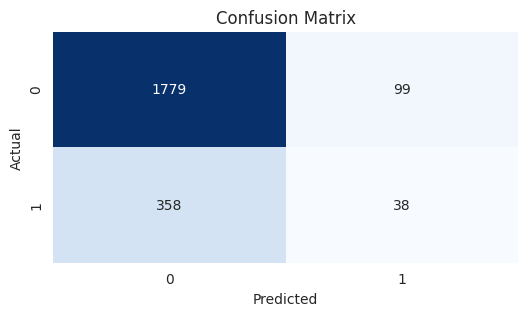

In [ ]:
# Compute confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 3))
sns.heatmap(cm_lstm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Summary & Conclusion

1. **Random Forest (RF)**:
  - Accuracy: Approximately 89.23%
  - Precision (Non-Disaster): 0.90
  - Recall (Non-Disaster): 0.97
  - Precision (Disaster): 0.81
  - Recall (Disaster): 0.50

2. **Neural Network (NN)**:
  - Accuracy: Approximately 89.60%
  - Precision (Non-Disaster): 0.93
  - Recall (Non-Disaster): 0.94
  - Precision (Disaster): 0.70
  - Recall (Disaster): 0.65

**Comparison**:

- Accuracy:
  - Both models have nearly identical accuracy, with the Neural Network slightly outperforming the Random Forest by about 0.37%.

- Non-Disaster Tweets:
  - The Neural Network has slightly higher precision for non-disaster tweets (0.93 vs 0.90 for RF).
  - The Random Forest has a significantly higher recall for non-disaster tweets (0.97 vs 0.94 for NN). This means that the Random Forest model is slightly better at capturing and correctly classifying non-disaster tweets.

- Disaster Tweets:
  - The Random Forest has higher precision for disaster tweets (0.81 vs 0.70 for NN). This indicates that the RF model, when predicting a tweet as a disaster, is more likely to be correct.
  - The Neural Network has a significantly higher recall for disaster tweets (0.65 vs 0.50 for RF). This means that the NN model is better at capturing and correctly classifying disaster tweets, even though it might make more false positives.

**Conclusion**:
- If the priority is to minimize false positives (i.e., non-disaster tweets being incorrectly labeled as disaster tweets), then the Random Forest model might be more suitable due to its higher precision for disaster tweets.
- On the other hand, if the priority is to capture as many disaster tweets as possible, even at the risk of some false positives, then the Neural Network model is preferable due to its higher recall for disaster tweets.

# Predictions

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.pipeline import make_pipeline
# from sklearn.neural_network import MLPClassifier

# # Splitting the balanced data into training and testing sets (80% train, 20% test)
# X_over = df['text']
# y_over = df['target']
# X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

# # Defining and training the Random Forest Classifier
# rf_pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=42))
# rf_pipeline.fit(X_train_over, y_train_over)

# # Predicting on the test set and evaluating performance
# rf_predictions = rf_pipeline.predict(X_test_over)
# rf_accuracy = accuracy_score(y_test_over, rf_predictions)

# # Defining and training the Neural Network (MLPClassifier)
# nn_pipeline = make_pipeline(TfidfVectorizer(), MLPClassifier(random_state=42))
# nn_pipeline.fit(X_train_over, y_train_over)

# # Predicting on the test set and evaluating performance
# nn_predictions = nn_pipeline.predict(X_test_over)
# nn_accuracy = accuracy_score(y_test_over, nn_predictions)

# rf_accuracy, nn_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


(0.8944591029023746, 0.9028144239226034)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# Splitting the data
X_over = df['text']
y_over = df['target']
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

# Random Forest and MLP pipelines
rf_pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=42))
rf_pipeline.fit(X_train_over, y_train_over)
rf_predictions = rf_pipeline.predict(X_test_over)
rf_accuracy = accuracy_score(y_test_over, rf_predictions)

nn_pipeline = make_pipeline(TfidfVectorizer(), MLPClassifier(random_state=42))
nn_pipeline.fit(X_train_over, y_train_over)
nn_predictions = nn_pipeline.predict(X_test_over)
nn_accuracy = accuracy_score(y_test_over, nn_predictions)

# LSTM
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X_train_over)
X_train_lstm = tokenizer.texts_to_sequences(X_train_over)
X_test_lstm = tokenizer.texts_to_sequences(X_test_over)

max_pad_length = 50
X_train_lstm = pad_sequences(X_train_lstm, maxlen=max_pad_length)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=max_pad_length)

model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_pad_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_lstm, y_train_over, epochs=5, batch_size=64, validation_data=(X_test_lstm, y_test_over), verbose=1)

lstm_predictions = model.predict(X_test_lstm)
lstm_predictions = [1 if pred > 0.5 else 0 for pred in lstm_predictions]
lstm_accuracy = accuracy_score(y_test_over, lstm_predictions)

rf_accuracy, nn_accuracy, lstm_accuracy

Epoch 1/5
143/143 [==============================] - 29s 172ms/step - loss: 0.3994 - accuracy: 0.8399 - val_loss: 0.2839 - val_accuracy: 0.8940
Epoch 2/5
143/143 [==============================] - 26s 178ms/step - loss: 0.2254 - accuracy: 0.9141 - val_loss: 0.2690 - val_accuracy: 0.8958
Epoch 3/5
143/143 [==============================] - 26s 182ms/step - loss: 0.1657 - accuracy: 0.9394 - val_loss: 0.2870 - val_accuracy: 0.8967
Epoch 4/5
143/143 [==============================] - 26s 181ms/step - loss: 0.1214 - accuracy: 0.9554 - val_loss: 0.3273 - val_accuracy: 0.8923
Epoch 5/5
72/72 [==============================] - 2s 20ms/step


(0.8944591029023746, 0.8931398416886543, 0.8940193491644679)

In [ ]:
import pandas as pd

def predict_tweets_disaster(tweets, model=nn_pipeline, model_type='nn'):
    """
    Predicts whether the provided tweets are about disasters and organizes predictions into a DataFrame.

    Parameters:
    - tweets (list of str): The tweets to be predicted.
    - model: The trained machine learning model.
    - model_type (str): Type of the model ('pipeline' for rf_pipeline and nn_pipeline, 'lstm' for LSTM model).

    Returns:
    - pd.DataFrame: A DataFrame with two columns - 'Tweet' and 'Prediction'.
    """
    processed_tweets = tweets
    # Convert tweets for LSTM model
    if model_type == 'lstm':
        processed_tweets = tokenizer.texts_to_sequences(tweets)
        processed_tweets = pad_sequences(processed_tweets, maxlen=50)
        predicted_probabilities = model.predict(processed_tweets)
        predicted_labels = [1 if pred > 0.5 else 0 for pred in predicted_probabilities]
    else:
        predicted_labels = model.predict(tweets)

    # Create a DataFrame to store the tweets and their predictions
    result_df = pd.DataFrame({'Tweet': tweets, 'Prediction': predicted_labels})

    return result_df


# Read the CSV file with tweet data into a DataFrame
csv_file_path = 'https://raw.githubusercontent.com/ashu198518/datasets/main/random_dsiaster_tweets_sample.csv'
tweet_data = pd.read_csv(csv_file_path)

# Extract the tweet text from the 'Text' column
tweets_to_predict = tweet_data['text'].tolist()


# # Example usage with a list of tweets
# tweet_list = [
#     "Forest fires rage on, consuming thousands of acres of woodland.",
#     "Just had a delicious lunch at the new restaurant downtown.",
#     "Earthquake reported in the coastal region.",
# ]

# Call the function to predict and organize the results
result_dataframe = predict_tweets_disaster(tweets_to_predict)

# Print the resulting DataFrame
result_dataframe.head(20)

,Tweet,Prediction
0,Hailstorm damages crops and property in the northern regions.,0
1,Hailstorm damages crops and property in the northern regions.,0
2,"Forest fires rage on, consuming thousands of acres of woodland.",1
3,Massive earthquake shakes the west coast causing widespread damage.,1
4,Massive earthquake shakes the west coast causing widespread damage.,1
5,Massive earthquake shakes the west coast causing widespread damage.,1
6,Severe drought in the southern parts causing crop failures.,1
7,Massive earthquake shakes the west coast causing widespread damage.,1
8,Multiple car pile-up on the highway due to dense fog.,0
9,Flood warnings issued for the eastern regions; residents are advised to evacuate.,1


Some example tweets to test out

Disaster-related tweets:

- "Massive earthquake shakes the west coast causing widespread damage."
- "Forest fires rage on, consuming thousands of acres of woodland."
- "Huge tornado spotted near the town center; residents are urged to seek shelter immediately."
- "Train derailment near the station; emergency services are on the scene."
- "Breaking: Terrorist attack at the city square; many feared dead."

Non-disaster tweets:

- "Listening to the new album and it's fire! 🔥"
- "The football match was explosive! What a game!"
- "Stuck in a traffic jam, feels like an endless road."
- "Just watched a movie about tsunamis; it was a thrilling experience."
- "The new burger joint in town is the bomb! Highly recommend."